creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure HEART not available!
Structure HEART not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 17 11:26:01 AM: Your problem has 18157 variables, 14 constraints, and 0 parameters.
(CVXPY) Jul 17 11:26:01 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 17 11:26:01 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 17 11:26:01 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation              

(CVXPY) Jul 17 11:28:09 AM: 21  5.4e-06  2.4e-04  1.5e-07  9.97e-01   6.885623398e+01   6.885590044e+01   4.5e-07  64.55 
(CVXPY) Jul 17 11:28:11 AM: 22  2.8e-06  1.3e-04  5.8e-08  9.97e-01   6.319117843e+01   6.319099956e+01   2.4e-07  66.59 
(CVXPY) Jul 17 11:28:13 AM: 23  2.2e-06  9.9e-05  3.9e-08  9.98e-01   6.182279417e+01   6.182265579e+01   1.8e-07  68.59 
(CVXPY) Jul 17 11:28:16 AM: 24  7.1e-07  3.2e-05  7.2e-09  9.98e-01   5.877349114e+01   5.877344572e+01   5.9e-08  71.61 
(CVXPY) Jul 17 11:28:18 AM: 25  4.7e-07  2.1e-05  3.9e-09  9.99e-01   5.834956200e+01   5.834953185e+01   3.9e-08  73.44 
(CVXPY) Jul 17 11:28:21 AM: 26  1.0e-07  4.7e-06  4.1e-10  9.99e-01   5.771511919e+01   5.771511243e+01   8.7e-09  76.28 
(CVXPY) Jul 17 11:28:24 AM: 27  1.6e-08  7.4e-07  2.5e-11  1.00e+00   5.758082438e+01   5.758082332e+01   1.4e-09  79.17 
(CVXPY) Jul 17 11:28:28 AM: 28  5.5e-09  2.5e-07  4.9e-12  1.00e+00   5.756473477e+01   5.756473441e+01   4.6e-10  83.16 
(CVXPY) Jul 17 11:28:31 

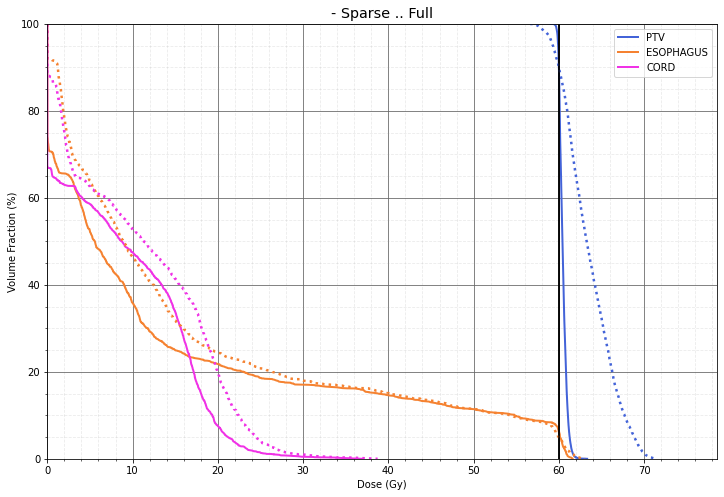

Done


In [ ]:
"""
### PortPy provides full dense influence matrix (i.e., including all scattering components) and a truncated sparse
    version (used for computational efficiency). This example clarifies the relationship and differences between
    these matrices by showing the followings:
    1- generating a plan using the sparse matrix (default matrix in PortPy)
    2- calculating the full dose for the plan using the full matrix
    3- manually calculating the sparse matrix from the full matrix
"""

import portpy.photon as pp
import numpy as np
import matplotlib.pyplot as plt


def ex_4_inf_matrix_sparsification():
    """
    1) generating a plan using the sparse matrix (default matrix in PortPy)

    """
    # Create plan_sparse object
    # By default, load_inf_matrix_full=False, and it only loads the sparse matrix
    data_dir = r'../data'
    data = pp.DataExplorer(data_dir=data_dir)
    patient_id = 'Lung_Patient_7'
    data.patient_id = patient_id

    # Load ct, structure and beams as an object
    ct = pp.CT(data)
    structs = pp.Structures(data)
    beams = pp.Beams(data)

    # create rinds based upon rind definition in optimization params
    opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
    structs.create_opt_structures(opt_params)

    # load influence matrix based upon beams and structure set
    inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

    # load clinical criteria from the config files for which plan to be optimized
    protocol_name = 'Lung_2Gy_30Fx'
    clinical_criteria = pp.ClinicalCriteria(data, protocol_name)

    # Create my_plan object which would load and store all the data needed for optimization
    plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)

    # create cvxpy problem using the clinical criteria and optimization parameters
    opt = pp.Optimization(plan_sparse, opt_params=opt_params)
    opt.create_cvxpy_problem()

    sol_sparse = opt.solve(solver='MOSEK', verbose=True)

    # Calculate the dose using the sparse matrix
    dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())

    """
    3) calculating the full dose for the plan using the full matrix
    
    """
    # Note: It is often computationally impractical to use the full matrix for optimization. We just use the
    #   full matrix to calculate the dose for the solution obtained by sparse matrix and show the resultant discrepancy

    # create plan_full object by specifying load_inf_matrix_full=True
    beams_full = pp.Beams(data, load_inf_matrix_full=True)
    # load influence matrix based upon beams and structure set
    inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
    plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
    # use the full influence matrix to calculate the dose for the plan obtained by sparse matrix
    dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

    # Visualize the DVH discrepancy
    struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = pp.Visualization.plot_dvh(plan_sparse, dose_1d=dose_sparse_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
    ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
    ax.set_title('- Sparse .. Full')
    plt.show()
    print('Done')

    """ 
    3) manually calculating the sparse matrix from the full matrix
    
    """
    # The sparse and full matrices are both pre-calculated and included in PorPy data.
    #   The sparse matrix; however, was obtained by simply zeroing out the small elements in the full matrix that were
    #   less than a threshold specified in "my_plan.inf_matrix.sparse_tol". Here, we manually generate the sparse
    #   matrix from the full matrix using this threshold to clarify the process

    #  Get A_sparse and A_full
    A_full = plan_full.inf_matrix.A
    A_sparse = plan_sparse.inf_matrix.A
    # Get the threshold value used by PortPy to truncate the matrix
    # sparse tol is 1% of the maximum of influence matrix of planner beams
    sparse_tol = plan_sparse.inf_matrix.sparse_tol
    # sparse_tol = 0.01*np.amax(A_full)

    # Truncate the full matrix
    A_full[A_full <= sparse_tol] = 0
    test = np.abs(A_full - A_sparse.todense()) <= 1e-3
    # Check if both influence matrices agree
    assert test.all()


if __name__ == "__main__":
    ex_4_inf_matrix_sparsification()


In [1]:
import portpy.photon as pp
import numpy as np
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
#opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
#structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

Creating BEV..
Loading sparse influence matrix...
Done


In [4]:
import portpy.photon as pp

data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Patient_7'
data.patient_id = patient_id

ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
beams_full = pp.Beams(data, load_inf_matrix_full=True)

protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)

inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)

plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)

#A_full = plan_full.inf_matrix.A
#A_sparse = plan_sparse.inf_matrix.A

#sparse_tol = plan_sparse.inf_matrix.sparse_tol

#A_full[A_full <= sparse_tol] = 0
#test = np.abs(A_full - A_sparse.todense()) <= 1e-3

# assert test.all()

Creating BEV..
Loading sparse influence matrix...
Done
Creating BEV..
Loading full influence matrix..
Done


In [5]:
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)

In [6]:
A_full = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A

In [7]:
m,n = A_full.shape
print(m,n)

373877 2679


In [8]:
##A_full.count_nonzero()    #Number of non-zero entries, equivalent to
import numpy as np
nonzero_count = np.count_nonzero(A_full)
print("تعداد مقادیر غیر صفر: ", nonzero_count)


تعداد مقادیر غیر صفر:  363297695


In [9]:
A_full.ndim

2

In [10]:
## بررسی اسپارس بودن ماتریس


from scipy import sparse

is_sparse = sparse.issparse(A_full)

is_sparse

False

In [11]:
r,p = A_sparse.shape
print(r,p)

373877 2679


In [13]:
A_sparse.getnnz()    #Number of non-zero entries, equivalent to

5779548

In [16]:
## بررسی اسپارس بودن ماتریس


from scipy import sparse

is_sparse = sparse.issparse(A_sparse)

is_sparse

True

In [15]:
A_sparse.format

'csr'

In [53]:
A_sparse.getmaxprint         #Maximum number of elements to display when printed.

<bound method spmatrix.getmaxprint of <373877x2679 sparse matrix of type '<class 'numpy.float32'>'
	with 5779548 stored elements in Compressed Sparse Row format>>

In [55]:
A_sparse.nonzero()    #nonzero indices

(array([ 54317,  54318,  54330, ..., 329775, 329775, 329912]),
 array([ 735,  734,  736, ..., 1881, 1882, 1881]))

In [76]:
# تریم کردن ماتریس کامل ـ صفر کردن درایه های زیر آستانه اش با،  sparse_tol
sparse_tol = plan_sparse.inf_matrix.sparse_tol 

##trimmed_A_full = (A_full[A_full <= sparse_tol] = 0)

trimmed_A_full = np.copy(A_full)
trimmed_A_full[trimmed_A_full <= sparse_tol] = 0


test = np.abs(A_full - A_sparse.todense()) <= 1e-3
assert test.all()

In [75]:
##trimmed_A_full = A_full[A_full <= sparse_tol]
##trimmed_A_full_shape = trimmed_A_full.shape
##print(f"trimmed_A_full_shape{trimmed_A_full_shape}")


In [77]:
trimmed_A_full.ndim

2

In [94]:
trimmed_A_full.shape

(373877, 2679)

In [78]:
nonzero_count = np.count_nonzero(trimmed_A_full)
print("تعداد مقادیر غیر صفر: ", nonzero_count)

##   همه مقادیر ماتریس  غیر صفر ??      
##    چرا با ماتریس فول برابره ؟؟؟  

تعداد مقادیر غیر صفر:  5779548


In [87]:
## ??????????


start_row =500 # شروع ردیف
end_row = 510# پایان ردیف
start_col = 500  # شروع ستون
end_col = 510  # پایان ستون

submatrix = A_full[start_row:end_row, start_col:end_col]
print("زیرماتریس:")
print(submatrix)


زیرماتریس:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [79]:
trimmed_A_full                     ##?????????????

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
import numpy as np

A_full_shape = (373877, 2679)

# تولید بردار تصادفی
random_vector = np.random.rand(A_full_shape[1])

###         چرا ابعاد بردار باید متناسب با ستون ماتریس باشه؟؟؟؟
print("ابعاد بردار تصادفی:", random_vector.shape)


ابعاد بردار تصادفی: (2679,)


In [97]:
m = 2679
n = 1
random_vector = np.random.rand(m * n).reshape(m, n)

In [98]:
W = np.matmul(A_full, random_vector)


In [99]:
W.shape

(373877, 1)

In [117]:
import numpy as np

trimmed_A_full_shape = (373877, 2679)

# تولید بردار تصادفی
random_vector = np.random.rand(trimmed_A_full_shape[1])

###         چرا ابعاد بردار باید متناسب با ستون ماتریس باشه؟؟؟؟
print("ابعاد بردار تصادفی:", random_vector.shape)


ابعاد بردار تصادفی: (2679,)


In [118]:
W_trim= np.matmul(trimmed_A_full, random_vector)
W_trim.shape

(373877,)